<a href="https://colab.research.google.com/github/AchrafAsh/gnn-receptive-fields/blob/main/00_knn_cora.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The goal of this notebook is to apply a simple **K-nearest neighbors on Cora** dataset to understand the labels of the graph.

*NB: it is actually a slightly modified version of the KNN where we consider a k-hop neighborhood and not k neighbors*

The expectations are:
- the influence of node locality is way more significant than node features, in other words, we can label nodes just by looking at its neighbors
- we can compute the graph problem radius by plotting the accuracy w.r.t the size of the neighborhood considered

## **Setting up the environment**

In [1]:
import os, sys
import os.path as osp
from google.colab import drive
drive.mount('/content/mnt')
nb_path = '/content/notebooks'
try:
    os.symlink('/content/mnt/My Drive/Colab Notebooks', nb_path)
except:
    pass
sys.path.insert(0, nb_path)  # or append(nb_path)

Mounted at /content/mnt


In [187]:
%%capture
!wget https://raw.githubusercontent.com/AchrafAsh/gnn-receptive-fields/main/data.py

from data import load_dataset

path = osp.join(os.getcwd(), 'data')
cora_dataset = load_dataset(path, 'Cora')
G = cora_dataset[0] # only graph of the dataset

num_test_nodes = G.test_mask.sum().item()

## **Building the model**

In [6]:
import torch

from collections import Counter
from torch_geometric.utils import to_dense_adj

In [4]:
A = to_dense_adj(G.edge_index)
A = A.squeeze(0)

In [ ]:
test_acc = 0
num_test_nodes = 0

for i in range(G.num_nodes):
    if G.test_mask[i]:
        num_test_nodes += 1
        neb_labels = []
        # count all the labels from its neighbors
        for j in range(G.num_nodes):
            if A[i, j] != 0:
                neb_labels += [G.y[j].item()]
        
        # find the most occurence in the neighborhood
        count = Counter(neb_labels)
        pred = max(count, key=lambda x: d[x])
        if pred == G.y[i]: test_acc += 1

In [ ]:
test_acc / num_test_nodes

0.789

That is what I thought 🤯
A KNN with a 1-hop neighborhood performs better than most graph neural networks!!!

But we cheated a little bit 🤭. We looked at neighbors regardless of whether they are part of our training set. Let's see what happens if we just consider nodes from our training set:

In [ ]:
test_acc = 0
num_test_nodes = 0
num_no_neighbors = 0

for i in range(G.num_nodes):
    if G.test_mask[i]:
        num_test_nodes += 1
        neb_labels = []
        # count all the labels from its neighbors
        for j in range(G.num_nodes):
            if A[i, j] != 0 and G.train_mask[j]:
                neb_labels += [G.y[j].item()]
        
        # find the most occurence in the neighborhood
        if len(neb_labels) != 0:
            count = Counter(neb_labels)
            pred = max(count, key=lambda x: d[x])
            if pred == G.y[i]: test_acc += 1
        else:
            num_no_neighbors += 1

In [ ]:
print(f"Test accuracy: {test_acc / num_test_nodes}")
print(f"{num_no_neighbors}/{num_test_nodes} () testing nodes had no training nodes in their direct neighborhood")

Test accuracy: 0.169
789/1000 testing nodes had no training nodes in their direct neighborhood


Ok now this an entirely different score. Most of our testing nodes are actually around other testing nodes.

Let's try to increase the neighborhood by one:

In [15]:
def get_k_hop_neighborhood(k:int, adj: torch.tensor) -> list:
    """Returns the list of nodes in the k-hop neighborhood (recursively)
    
    Args:
        - k (int): size of the neighborhood
        - i (int): index of the target node
        - adj [num_nodes, num_nodes]: dense adjacency matrix
    """
    
    k_hop_neb = [adj.clone()]
    pow_A = adj.clone()

    for l in range(k-1):
        pow_A = torch.mm(adj, pow_A)
        k_neb = torch.where(
            torch.where(pow_A > 0, 1, 0) - sum(k_hop_neb) > 0,
            1,
            0
        )
        k_hop_neb.append(k_neb)
    
    return k_hop_neb

In [ ]:
K = 2
test_acc = 0
num_no_neighbors = 0

for i in range(G.num_nodes):
    if G.test_mask[i]:
        num_test_nodes += 1
        neb_labels = []
        # count all the labels from its neighbors
        neb_labels = [G.y[j] for j in get_k_hop_neighborhood(K, i, A) if G.train_mask[j]]
        
        # find the most occurence in the neighborhood
        if len(neb_labels) != 0:
            count = Counter(neb_labels)
            pred = max(count, key=lambda x: d[x])
            if pred == G.y[i]: test_acc += 1
        else:
            num_no_neighbors += 1

In [ ]:
print(f"Test accuracy: {test_acc / num_test_nodes}")
print(f"{num_no_neighbors}/{num_test_nodes} testing nodes had no training nodes in their direct neighborhood")

Test accuracy: 0.00016900000000000002
382/1000 testing nodes had no training nodes in their direct neighborhood


Ok this already much better, this is in comparison with a 2-layer GCN which performs the best (0.81).

## **Finding the right depth**

Now let's put all of this into a function and run it over several neighborhood sizes to see how our performance evolves

In [32]:
def run(k: int):
    test_acc = 0
    num_test_nodes = 0
    num_no_neighbors = 0
    k_neb = sum(get_k_hop_neighborhood(k, A+torch.eye(A.size(0))))

    for i in range(G.num_nodes):
        if G.test_mask[i]:
            num_test_nodes += 1
            neb_labels = []
            # count all the labels from its neighbors
            neb_labels = [G.y[j] for j in range(A.size(0)) if G.train_mask[j] and k_neb[i,j] == 1]
            
            # find the most occurence in the neighborhood
            if len(neb_labels) != 0:
                count = Counter(neb_labels)
                pred = max(count, key=lambda x: count[x])
                if pred == G.y[i]: test_acc += 1
            else:
                num_no_neighbors += 1
    
    return test_acc/num_test_nodes, num_no_neighbors

In [34]:
all_test_acc, all_num_no_neb = [], []
for k in range(1, 7):
    test_acc, num_no_neb = run(k)
    all_test_acc.append(test_acc)
    all_num_no_neb.append(num_no_neb)
    
    print(f"k: {k} | test_acc: {test_acc} | num_no_neb: {num_no_neb}")

k: 1 | test_acc: 169 | num_no_neb: 789
k: 2 | test_acc: 413 | num_no_neb: 382
k: 3 | test_acc: 439 | num_no_neb: 186
k: 4 | test_acc: 401 | num_no_neb: 101
k: 5 | test_acc: 361 | num_no_neb: 76
k: 6 | test_acc: 339 | num_no_neb: 66


In [151]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style('darkgrid')

[Text(0.5, 1.0, 'KNN on Cora')]

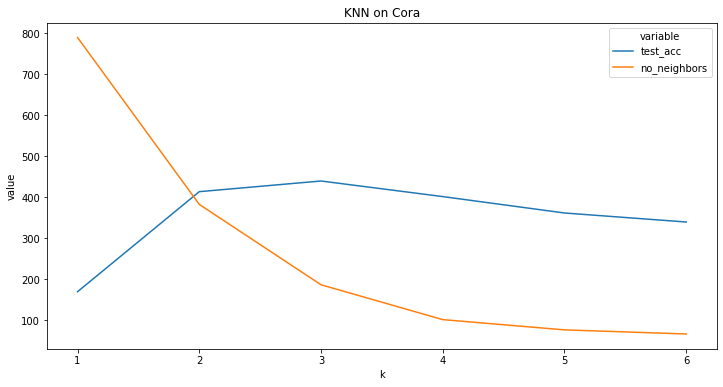

In [37]:
plt.figure(figsize=(12, 6))


data = pd.DataFrame({
    'k': range(1, 7),
    'test_acc': all_test_acc,
    'no_neighbors': all_num_no_neb
})

sns.lineplot(x='k', y='value', hue='variable', data=pd.melt(data, ['k'])).set(title="KNN on Cora")

Even with a depth of 3 we keep getting better results (the vanilla GCN lose its accuracy after 2 layers).

<strong>TODO: measure the threshold for uninformative receptive field (ratio between same class nodes and different class nodes):
<br/>
$$
informative-ratio(v) = \frac{ \left| \{ u \in \mathcal N(v) | c(u) = c(v) \} \right| }{  \left| \{ u \in \mathcal N(v) | c(u) \neq c(v) \} \right| }
$$
<strong/>

## **Measuring uninformative receptive fields**

In [81]:
G.train_mask * torch.ones(G.num_nodes)

tensor([1., 1., 1.,  ..., 0., 0., 0.])

In [92]:
G.y[A[10]==1]

tensor([1, 1])

In [138]:
def informative_ratio(i:int, neb:torch.tensor, mask=None):
    """
    Args:
        - i: index of a node
        - neb [num_nodes, num_nodes]: neighbors to consider (can be the adjacency matrix or k-hop neighborhood)
        - mask [num_nodes]: "train", "test" or "val" to consider only these specific neighbors
    """
    if mask == None:
        mask = torch.ones(G.num_nodes)

    labels = G.y[neb[i] * mask == 1]
    # labels = torch.tensor([G.y[j] for j in range(G.num_nodes) if neb[i,j] == 1 and mask[j]])

    if len(labels) == 0: return 0
    
    return (labels == G.y[i]).sum().item() / len(labels)

In [108]:
torch.tensor([informative_ratio(i, A) for i in range(G.num_nodes)]).mean()

tensor(0.8252)

In [109]:
nebs = get_k_hop_neighborhood(10, A)

In [182]:
info_ratio = pd.DataFrame(columns=['k', 'ratio', 'hop_ratio', 'all_neb'])

In [183]:
test_idx = [i for i in range(G.num_nodes) if G.test_mask[i]]
neb = torch.zeros(G.num_nodes, G.num_nodes)

for k in range(1, 10):
    neb = neb + nebs[k-1]
    
    ratio = torch.tensor(
        [informative_ratio(i, neb, mask=G.train_mask) for i in test_idx]
    ).mean().item()
    hop_ratio = torch.tensor(
        [informative_ratio(i, nebs[k-1], mask=G.train_mask) for i in test_idx]
    ).mean().item()
    all_neb_ratio = torch.tensor(
        [informative_ratio(i, nebs[k-1]) for i in test_idx]
    ).mean().item() 
    
    info_ratio.loc[k-1] = {'k':k, 'ratio':ratio, 'hop_ratio': hop_ratio, 'all_neb': all_neb_ratio}

    print(f"k: {k} | ratio: {ratio} | hop-ratio: {hop_ratio} | all neighbors: {all_neb_ratio}")

k: 1 | ratio: 0.16891667246818542 | hop-ratio: 0.16891667246818542 | all neighbors: 0.816875696182251
k: 2 | ratio: 0.45707565546035767 | hop-ratio: 0.3880768418312073 | all neighbors: 0.7619004249572754
k: 3 | ratio: 0.4762896001338959 | hop-ratio: 0.37553074955940247 | all neighbors: 0.5438345074653625
k: 4 | ratio: 0.39577797055244446 | hop-ratio: 0.2910778820514679 | all neighbors: 0.3777962625026703
k: 5 | ratio: 0.29598456621170044 | hop-ratio: 0.1808316707611084 | all neighbors: 0.24327242374420166
k: 6 | ratio: 0.23052231967449188 | hop-ratio: 0.11646512895822525 | all neighbors: 0.16547228395938873
k: 7 | ratio: 0.1963481456041336 | hop-ratio: 0.08987057954072952 | all neighbors: 0.12800486385822296
k: 8 | ratio: 0.17813144624233246 | hop-ratio: 0.06578488647937775 | all neighbors: 0.11155708879232407
k: 9 | ratio: 0.16906602680683136 | hop-ratio: 0.04480306804180145 | all neighbors: 0.10523762553930283


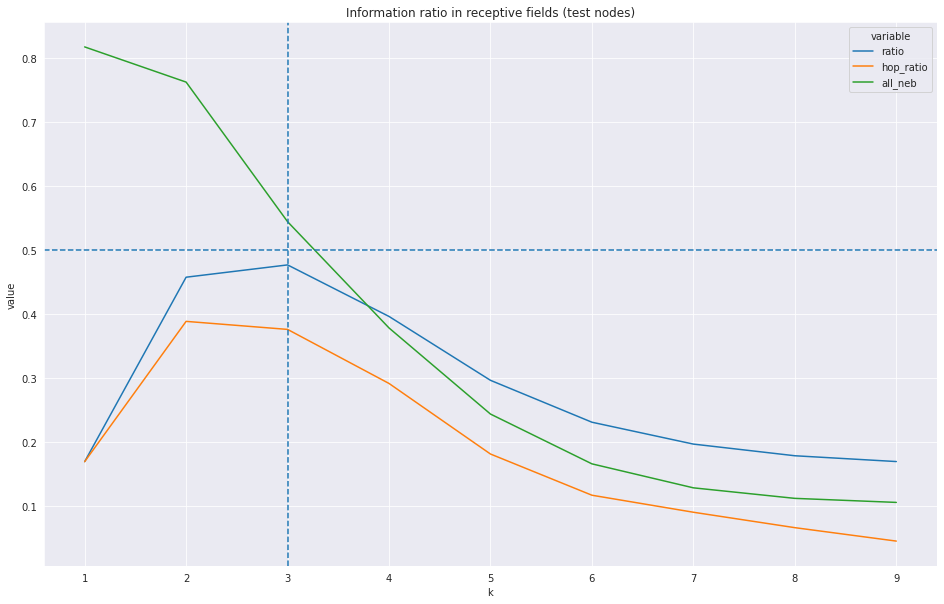

In [184]:
plt.figure(figsize=(16, 10))
sns.lineplot(x='k', y='value', hue='variable', data=pd.melt(info_ratio.astype('float64'), ['k'])).set(title="Information ratio in receptive fields (test nodes)")
plt.axvline(x=3, linestyle='--')
plt.axhline(y=.5, linestyle='--')

_info: the target nodes considered are from the test set, and only the nodes from the training set were considered in the information ratio_

We should also note that in smaller neighborhoods, most nodes from the test set do not have any neighbors from the training set. This explains why the ratio is so low at the beginning (and not because direct neighbors are from different classes).

## **More hyperparameters**

Now let's try something different. We will run the KNN several time so that after labelling the nodes that we can label, we will have new neighbors to consider.
So we now have two hyperparameters:
- k: the size of the neighborhood
- n: the number of time we want to run the KNN

In [201]:
def run_and_label(labels:list, neb:torch.tensor):
    """Run KNN on test set with already labelled nodes and returns the new 
    labels, updated accuracy and the number of nodes from the test set that do not have neighbors from the training set.

    Args:
        - labels [num_nodes]: all the labels where unlabelled nodes are set to -1
        - neb [num_nodes, num_nodes]: neighbors to consider (can be adjacency matrix or k-hop neighborhood)
    """

    test_acc, num_no_neighbors = 0, 0
    new_labels = labels.clone()

    for i in range(G.num_nodes):
        if G.test_mask[i] and labels[i] == -1: # to avoid labelling nodes already labelled
            neb_labels = labels[neb[i] * (labels!=-1) == 1] # nodes from the training set and labelled nodes only
            
            # find the most occurence in the neighborhood
            if len(neb_labels) != 0:
                count = Counter(neb_labels)
                pred = max(count, key=lambda x: count[x])
                new_labels[i] = pred.item()
                if pred == G.y[i]: test_acc += 1
            else:
                num_no_neighbors += 1
    
    return new_labels, test_acc/num_test_nodes, num_no_neighbors

In [208]:
k_neb = get_k_hop_neighborhood(k=6, adj=A)

results = pd.DataFrame(columns=['k', 'n', 'test_acc', 'no_neb'])
id = 0

for k in range(1, 7):
    labels = torch.where(G.train_mask, G.y, -1)
    for n in range(1, 7):
        labels, test_acc, no_neb = run_and_label(labels, neb=k_neb[k-1])
        results.loc[id] = {'k':k, 'n':n, 'test_acc': test_acc, 'no_neb': no_neb}
        id += 1

        print(f"k: [{k}/3] | n: [{n}/3] | acc: {test_acc} | no_neighbors: {no_neb}")

k: [1/3] | n: [1/3] | acc: 0.169 | no_neighbors: 789
k: [1/3] | n: [2/3] | acc: 0.137 | no_neighbors: 589
k: [1/3] | n: [3/3] | acc: 0.059 | no_neighbors: 500
k: [1/3] | n: [4/3] | acc: 0.029 | no_neighbors: 453
k: [1/3] | n: [5/3] | acc: 0.01 | no_neighbors: 429
k: [1/3] | n: [6/3] | acc: 0.004 | no_neighbors: 422
k: [2/3] | n: [1/3] | acc: 0.34 | no_neighbors: 459
k: [2/3] | n: [2/3] | acc: 0.126 | no_neighbors: 186
k: [2/3] | n: [3/3] | acc: 0.022 | no_neighbors: 139
k: [2/3] | n: [4/3] | acc: 0.002 | no_neighbors: 136
k: [2/3] | n: [5/3] | acc: 0.0 | no_neighbors: 136
k: [2/3] | n: [6/3] | acc: 0.0 | no_neighbors: 136
k: [3/3] | n: [1/3] | acc: 0.336 | no_neighbors: 247
k: [3/3] | n: [2/3] | acc: 0.075 | no_neighbors: 95
k: [3/3] | n: [3/3] | acc: 0.004 | no_neighbors: 91
k: [3/3] | n: [4/3] | acc: 0.0 | no_neighbors: 91
k: [3/3] | n: [5/3] | acc: 0.0 | no_neighbors: 91
k: [3/3] | n: [6/3] | acc: 0.0 | no_neighbors: 91
k: [4/3] | n: [1/3] | acc: 0.288 | no_neighbors: 135
k: [4/3] |

In [209]:
results

,k,n,test_acc,no_neb
0,1,1,0.169,789
1,1,2,0.137,589
2,1,3,0.059,500
3,1,4,0.029,453
4,1,5,0.010,429
5,1,6,0.004,422
6,2,1,0.340,459
7,2,2,0.126,186
8,2,3,0.022,139
9,2,4,0.002,136


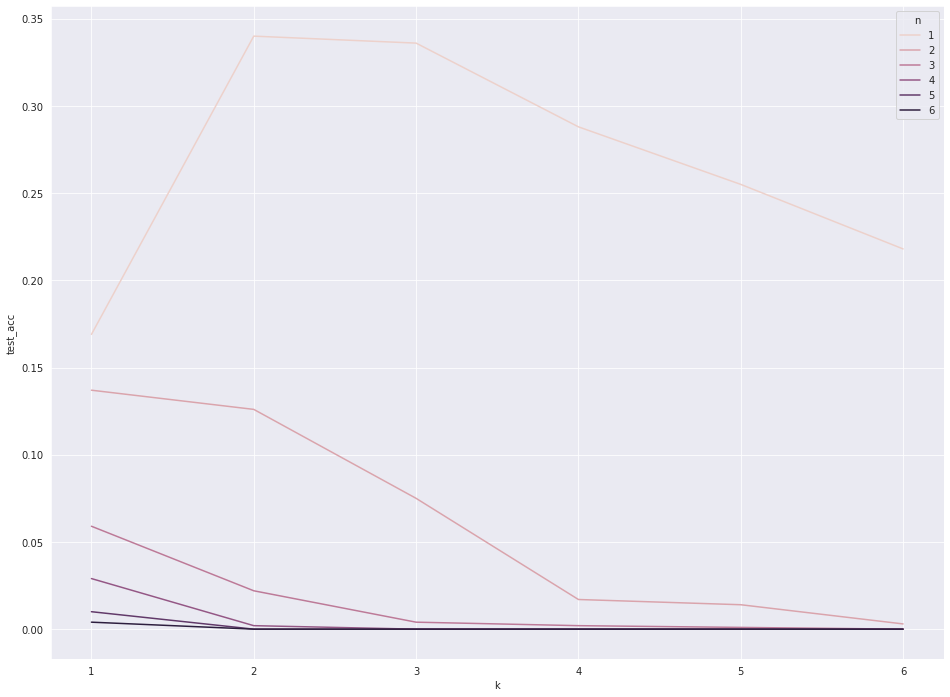

In [211]:
plt.figure(figsize=(16, 12))

sns.lineplot(x='k', y='test_acc', data=results, hue='n')

[Text(0.5, 1.0, 'Testing accuracy of the KNN with different neighborhood depth')]

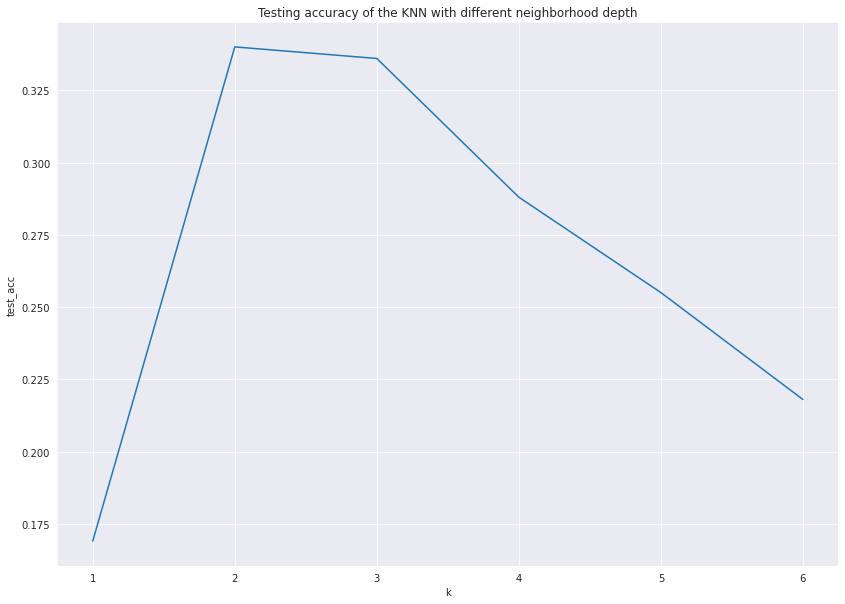

In [222]:
plt.figure(figsize=(14, 10))

sns.lineplot(x=results['k'], y=results[results['n']==1]['test_acc'], data=results).set(title='Testing accuracy of the KNN with different neighborhood depth')